# Financial Statements Classification - ResNet50 Model

ResNet50 (Residual Network with 50 Layers) is a deep CNN architecture that is known for its reliable performance on image classification.

It was chosen as a starting, baseline model sine I am already familiar with it, and kept its structure without any further tuning.

---

### Information

**Input Size:** 224x224  

**Parameters:** ~23.5 Million

**Depth:** 50 Layers

---

### Structure
```
Input: 224x224x3 RGB Image
    ↓
Conv Layer (7×7, stride 2) + MaxPool
    ↓
Residual Block 1 (3 layers) × 3 repetitions
    ↓
Residual Block 2 (4 layers) × 4 repetitions  
    ↓
Residual Block 3 (6 layers) × 6 repetitions
    ↓
Residual Block 4 (3 layers) × 3 repetitions
    ↓
Global Average Pooling
    ↓
Fully Connected Layer → 5 classes
```

---
# Installing Packages & Importing Libraries

In [1]:
!pip install -q torch torchvision timm albumentations opencv-python-headless

In [2]:
import os
import sys
import json
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cpu


---
# Loading Data & Configurations

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Paths
BASE_DIR = '/content/drive/MyDrive/Sukuk AI Assessment/FS_Classification'
CONFIG_FILE = os.path.join(BASE_DIR, 'config.json')

# Load config
with open(CONFIG_FILE, 'r') as f:
    config = json.load(f)

# Extract settings
MODEL_NAME = 'resnet50'
MODEL_CONFIG = config['model_configs'][MODEL_NAME]
CLASS_NAMES = config['class_names']
NUM_CLASSES = len(CLASS_NAMES)
INPUT_SIZE = MODEL_CONFIG['input_size']
MEAN = MODEL_CONFIG['mean']
STD = MODEL_CONFIG['std']

# Training hyperparameters
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4

# Output directory for this model
MODEL_DIR = os.path.join(BASE_DIR, MODEL_NAME)
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"Model: {MODEL_NAME}")
print(f"Input Size: {INPUT_SIZE}x{INPUT_SIZE}")
print(f"Classes: {NUM_CLASSES}")
print(f"Output: {MODEL_DIR}")

Model: resnet50
Input Size: 224x224
Classes: 5
Output: /content/drive/MyDrive/Sukuk AI Assessment/FS_Classification/resnet50


In [5]:
# Load splits
train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_DIR, 'val.csv'))
test_df = pd.read_csv(os.path.join(BASE_DIR, 'test.csv'))

# Load class weights
class_weights = torch.load(os.path.join(BASE_DIR, 'class_weights.pt'))
class_weights = class_weights.to(DEVICE)

print(f"Train: {len(train_df)} samples")
print(f"Val:   {len(val_df)} samples")
print(f"Test:  {len(test_df)} samples")
print(f"\nClass weights: {class_weights}")

Train: 825 samples
Val:   177 samples
Test:  177 samples

Class weights: tensor([1.2199, 1.0797, 0.2409, 0.4175, 2.0420])


---
# Training Setting Up

In [6]:
# Training transforms with augmentation
train_transform = A.Compose([
    A.LongestMaxSize(max_size=int(INPUT_SIZE * 1.15)),
    A.PadIfNeeded(
        min_height=int(INPUT_SIZE * 1.15),
        min_width=int(INPUT_SIZE * 1.15),
        border_mode=cv2.BORDER_CONSTANT,
        value=(255, 255, 255)
    ),
    A.RandomCrop(height=INPUT_SIZE, width=INPUT_SIZE),

    # Light augmentations for documents
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=5,
        border_mode=cv2.BORDER_CONSTANT,
        value=(255, 255, 255),
        p=0.5
    ),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 5), p=1.0),
        A.MotionBlur(blur_limit=3, p=1.0),
    ], p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),

    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

# Validation/Test transforms (no augmentation)
val_transform = A.Compose([
    A.LongestMaxSize(max_size=INPUT_SIZE),
    A.PadIfNeeded(
        min_height=INPUT_SIZE,
        min_width=INPUT_SIZE,
        border_mode=cv2.BORDER_CONSTANT,
        value=(255, 255, 255)
    ),
    A.CenterCrop(height=INPUT_SIZE, width=INPUT_SIZE),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

/tmp/ipython-input-3438037984.py:4: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3438037984.py:13: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipython-input-3438037984.py:34: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(


In [7]:
class FinancialStatementsDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_path = row['image_path']
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transforms
        if self.transform:
            image = self.transform(image=image)['image']

        label = row['label_encoded']

        return image, label

In [8]:
# Create datasets
train_dataset = FinancialStatementsDataset(train_df, transform=train_transform)
val_dataset = FinancialStatementsDataset(val_df, transform=val_transform)
test_dataset = FinancialStatementsDataset(test_df, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 52
Val batches: 12
Test batches: 12


In [9]:
# Create model using timm
model = timm.create_model(
    MODEL_CONFIG['timm_name'],
    pretrained=True,
    num_classes=NUM_CLASSES
)

model = model.to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: {MODEL_NAME}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Model: resnet50
Total parameters: 23,518,277
Trainable parameters: 23,518,277


---
# Model Training

In [11]:
# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)

In [12]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({
            'loss': running_loss / (pbar.n + 1),
            'acc': 100. * correct / total
        })

    return running_loss / len(loader), 100. * correct / total


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({
                'loss': running_loss / (pbar.n + 1),
                'acc': 100. * correct / total
            })

    return running_loss / len(loader), 100. * correct / total, all_preds, all_labels

In [ ]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_epoch = 0

print(f"Training {MODEL_NAME}")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 60)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)

    # Validate
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, DEVICE)

    # Update scheduler
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, os.path.join(MODEL_DIR, 'best_model.pth'))
        print(f"New best model saved! (Val Acc: {val_acc:.2f}%)")

print(f"Training Complete!")
print(f"Best Val Acc: {best_val_acc:.2f}% (Epoch {best_epoch})")

Training resnet50

Epoch 1/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.06s/it, loss=1.52, acc=49.2]



Results:
  Train Loss: 1.5821 | Train Acc: 47.88%
  Val Loss:   1.5176 | Val Acc:   49.15%
New best model saved! (Val Acc: 49.15%)

Epoch 2/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.63s/it, loss=1.39, acc=63.3]



Results:
  Train Loss: 1.4925 | Train Acc: 58.18%
  Val Loss:   1.3859 | Val Acc:   63.28%
New best model saved! (Val Acc: 63.28%)

Epoch 3/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.62s/it, loss=1.18, acc=77.4]



Results:
  Train Loss: 1.3513 | Train Acc: 69.58%
  Val Loss:   1.1753 | Val Acc:   77.40%
New best model saved! (Val Acc: 77.40%)

Epoch 4/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.68s/it, loss=1.01, acc=74.6]



Results:
  Train Loss: 1.1515 | Train Acc: 74.55%
  Val Loss:   1.0055 | Val Acc:   74.58%

Epoch 5/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:42<00:00,  3.51s/it, loss=0.812, acc=80.2]



Results:
  Train Loss: 0.8974 | Train Acc: 73.09%
  Val Loss:   0.8118 | Val Acc:   80.23%
New best model saved! (Val Acc: 80.23%)

Epoch 6/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:42<00:00,  3.58s/it, loss=0.629, acc=79.7]



Results:
  Train Loss: 0.6415 | Train Acc: 77.45%
  Val Loss:   0.6290 | Val Acc:   79.66%

Epoch 7/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:42<00:00,  3.53s/it, loss=0.486, acc=83.6]



Results:
  Train Loss: 0.4949 | Train Acc: 81.82%
  Val Loss:   0.4857 | Val Acc:   83.62%
New best model saved! (Val Acc: 83.62%)

Epoch 8/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.64s/it, loss=0.338, acc=92.1]



Results:
  Train Loss: 0.4017 | Train Acc: 83.88%
  Val Loss:   0.3380 | Val Acc:   92.09%
New best model saved! (Val Acc: 92.09%)

Epoch 9/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.14s/it, loss=0.28, acc=91]



Results:
  Train Loss: 0.3857 | Train Acc: 85.21%
  Val Loss:   0.2802 | Val Acc:   90.96%

Epoch 10/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:52<00:00,  4.34s/it, loss=0.305, acc=89.3]



Results:
  Train Loss: 0.3267 | Train Acc: 87.27%
  Val Loss:   0.3047 | Val Acc:   89.27%

Epoch 11/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.61s/it, loss=0.252, acc=89.8]



Results:
  Train Loss: 0.2991 | Train Acc: 88.73%
  Val Loss:   0.2521 | Val Acc:   89.83%

Epoch 12/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:50<00:00,  4.19s/it, loss=0.263, acc=89.8]



Results:
  Train Loss: 0.2594 | Train Acc: 88.12%
  Val Loss:   0.2632 | Val Acc:   89.83%

Epoch 13/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.14s/it, loss=0.281, acc=91.5]



Results:
  Train Loss: 0.2301 | Train Acc: 89.45%
  Val Loss:   0.2811 | Val Acc:   91.53%

Epoch 14/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.12s/it, loss=0.199, acc=91]



Results:
  Train Loss: 0.1904 | Train Acc: 90.91%
  Val Loss:   0.1985 | Val Acc:   90.96%

Epoch 15/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:51<00:00,  4.31s/it, loss=0.211, acc=93.2]



Results:
  Train Loss: 0.1888 | Train Acc: 91.88%
  Val Loss:   0.2114 | Val Acc:   93.22%
New best model saved! (Val Acc: 93.22%)

Epoch 16/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.12s/it, loss=0.149, acc=94.4]



Results:
  Train Loss: 0.1961 | Train Acc: 93.09%
  Val Loss:   0.1490 | Val Acc:   94.35%
New best model saved! (Val Acc: 94.35%)

Epoch 17/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.64s/it, loss=0.168, acc=92.1]



Results:
  Train Loss: 0.1674 | Train Acc: 91.39%
  Val Loss:   0.1678 | Val Acc:   92.09%

Epoch 18/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:42<00:00,  3.52s/it, loss=0.194, acc=92.1]



Results:
  Train Loss: 0.1751 | Train Acc: 93.45%
  Val Loss:   0.1939 | Val Acc:   92.09%

Epoch 19/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:42<00:00,  3.53s/it, loss=0.159, acc=93.2]



Results:
  Train Loss: 0.1763 | Train Acc: 92.73%
  Val Loss:   0.1592 | Val Acc:   93.22%

Epoch 20/20
------------------------------------------------------------


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.59s/it, loss=0.147, acc=94.4]


Results:
  Train Loss: 0.1729 | Train Acc: 92.85%
  Val Loss:   0.1474 | Val Acc:   94.35%
Training Complete!
Best Val Acc: 94.35% (Epoch 16)


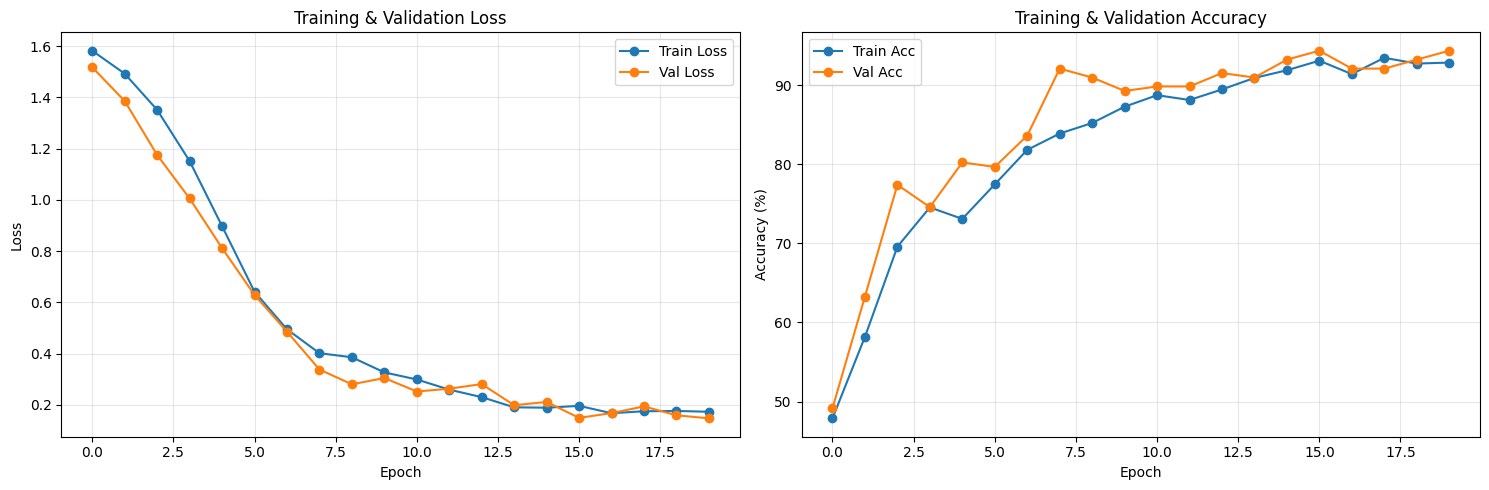

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training & Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

# Save history
pd.DataFrame(history).to_csv(os.path.join(MODEL_DIR, 'training_history.csv'), index=False)

---
# Evaluation on Test Set

In [17]:
# Load best model
checkpoint = torch.load(os.path.join(MODEL_DIR, 'best_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")

# Evaluate
test_loss, test_acc, test_preds, test_labels = validate(model, test_loader, criterion, DEVICE)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Loaded best model from epoch 16


Validation: 100%|██████████| 12/12 [01:07<00:00,  5.67s/it, loss=0.146, acc=93.2]


Test Loss: 0.1457
Test Accuracy: 93.22%


In [18]:
# Classification report
report = classification_report(test_labels, test_preds, target_names=CLASS_NAMES, digits=4)
print(report)

# Save report
with open(os.path.join(MODEL_DIR, 'classification_report.txt'), 'w') as f:
    f.write(report)

                              precision    recall  f1-score   support

Independent Auditor's Report     0.8095    1.0000    0.8947        17
            Financial Sheets     0.8947    0.9444    0.9189        18
             Notes (Tabular)     0.9868    0.8929    0.9375        84
                Notes (Text)     0.9020    0.9583    0.9293        48
                 Other Pages     1.0000    1.0000    1.0000        10

                    accuracy                         0.9322       177
                   macro avg     0.9186    0.9591    0.9361       177
                weighted avg     0.9382    0.9322    0.9328       177



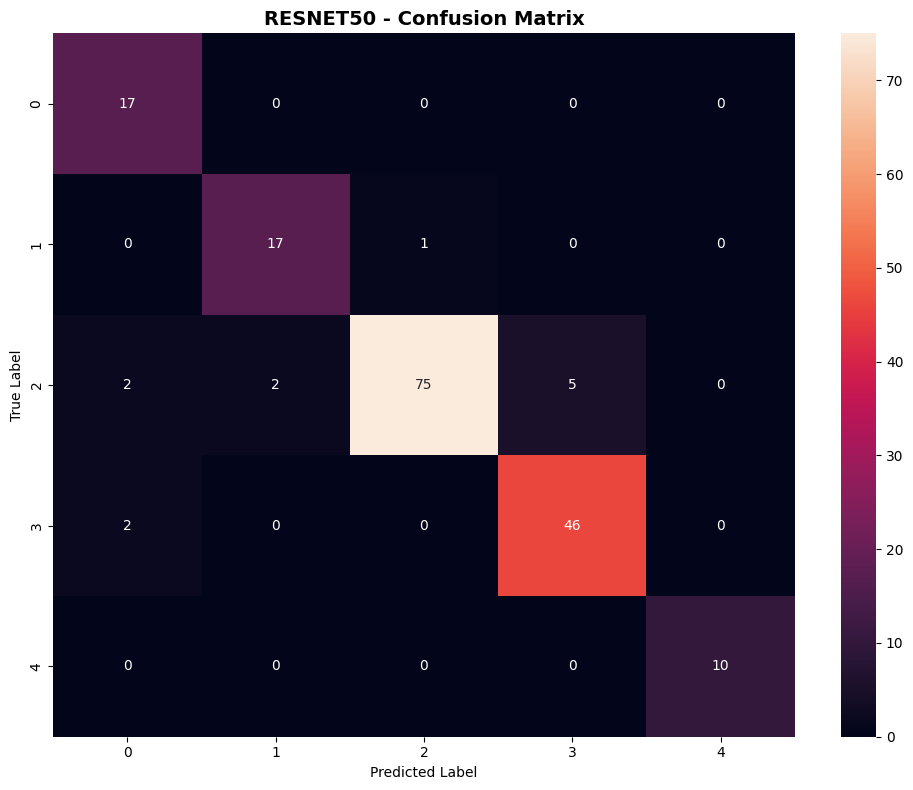

In [19]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
    xticklabels=[f"{i}" for i in range(NUM_CLASSES)],
    yticklabels=[f"{i}" for i in range(NUM_CLASSES)])
plt.title(f'{MODEL_NAME.upper()} - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# Save confusion matrix
np.save(os.path.join(MODEL_DIR, 'confusion_matrix.npy'), cm)

In [ ]:
# Save final results
results = {
    'model': MODEL_NAME,
    'input_size': INPUT_SIZE,
    'best_epoch': best_epoch,
    'best_val_acc': float(best_val_acc),
    'test_acc': float(test_acc),
    'test_loss': float(test_loss),
    'total_params': total_params,
    'trainable_params': trainable_params,
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'num_epochs': NUM_EPOCHS,
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
    }
}

with open(os.path.join(MODEL_DIR, 'results.json'), 'w') as f:
    json.dump(results, f, indent=2)

print("\nAll results saved to:", MODEL_DIR)
print("\nFiles created:")
for f in os.listdir(MODEL_DIR):
    print(f"  - {f}")